In [1]:
%matplotlib inline

In [2]:
# 引入模块
import numpy as np
from matplotlib import pyplot as plt
import mne
from mne.preprocessing import (ICA, create_eog_epochs)
from mne.datasets import sample
from mne.channels import (read_montage,
                          read_dig_montage)
import os

In [3]:
# 定义变量
bads = ['TP9', 'TP10'] # 坏道（不需要分析的通道）
events_id = {'f/neg': 11,
             's/neg': 22,
             'f/neu': 33,
             'r/neg': 44,
             'sr/neg': 55}
tmin, tmax = -0.2, 4.0 # 分段范围
baseline = (None, 0) # 基线矫正范围
reject = dict(eeg=80e-6) # 删除伪迹之后的
reject_ica = dict(eeg=200e-6) # peak-to-peak reject
l_freq, h_freq, sfreq = 1, 40, 250 # 滤波和重采样
method = 'fastica' # ica算法

In [4]:
# --------------- prepare directory ---------------
fext = '.set'
fpath = os.path.expanduser('~') + '/toolbox/mne-demo/mne-data/'
fdata = filter(lambda x: x.endswith(fext), os.listdir(fpath))

In [5]:
fdata

['1canyu_merge.set']

In [6]:
# --------------- preprocessing ---------------
raw = mne.io.read_raw_eeglab(os.path.join(fpath, fdata[0]),
                             eog=('VEOD', 'HEOL', 'VEOU', 'HEOR'),
                             event_id=events_id,
                             preload=True)
montage = read_montage('standard_1020')
raw.set_montage(montage)
raw.info['bads'] = ['M2']
#raw.info['custom_ref_applied'] = False
#raw_avg_ref, _ = mne.io.set_eeg_reference(raw, ref_channels=[])

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary', 'empty'], 2 in total
9/209 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading /Users/lix/toolbox/mne-demo/mne-data/1canyu_merge.fdt
Reading 0 ... 669579  =      0.000 ...  1339.158 secs...


<ipython-input-6-a223fd613c3d>:5: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  preload=True)
<ipython-input-6-a223fd613c3d>:5: RuntimeWarning: Events like the following will be dropped entirely: ['boundary', 'empty'], 2 in total
  preload=True)
<ipython-input-6-a223fd613c3d>:5: RuntimeWarning: 9/209 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  preload=True)


In [9]:
mne.io.read_raw_eeglab?

In [59]:
# --------------- preprocessing ---------------
raw = mne.io.read_raw_brainvision(os.path.join(fpath, fdata[0]),
                                  eog=('VEO', 'HEOR'),
                                  preload=True)
# raw = mne.add_reference_channels(raw, 'FCz', copy=False)
montage = read_montage('standard_1020')
raw.set_montage(montage)
raw.info['bads'] = bads
# raw.info['custom_ref_applied'] = False
raw_no_ref, _ = mne.io.set_eeg_reference(raw, ref_channels=[])
picks = mne.pick_types(raw_no_ref.info,
                       eeg=True,
                       exclude='bads')

Extracting parameters from /Users/lix/toolbox/mne-demo/mne-data/s3-er.vhdr...
Online software filter detected. Using software filter settings and ignoring hardware values
Setting channel info structure...
Reading 0 ... 1211219  =      0.000 ...  2422.438 secs...


<ipython-input-59-6fbf09957dc6>:4: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True)


Applying a custom EEG reference.


200 events found
Events id: [11 22 33 44 55]


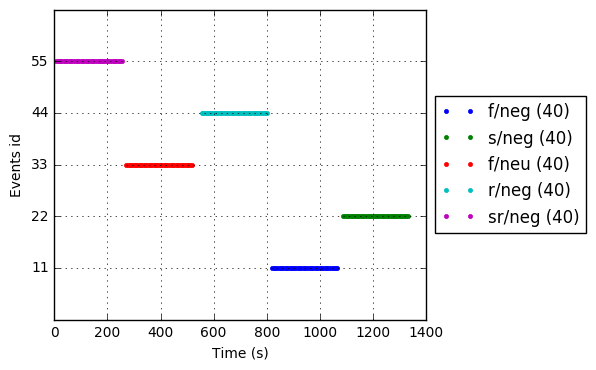

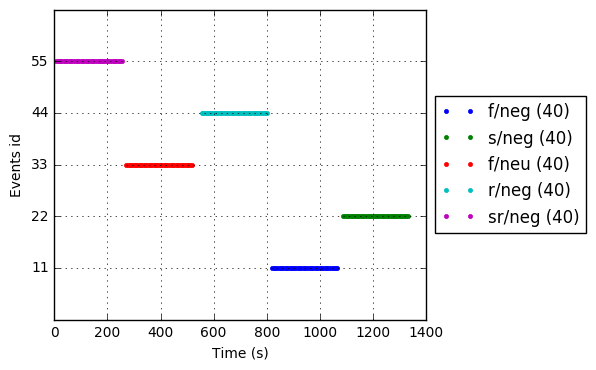

In [25]:
# plot events
events = mne.find_events(raw)
mne.viz.plot_events(events, raw.info['sfreq'],
                    raw.first_samp,
                    event_id=events_id)

Effective window size : 4.096 (s)


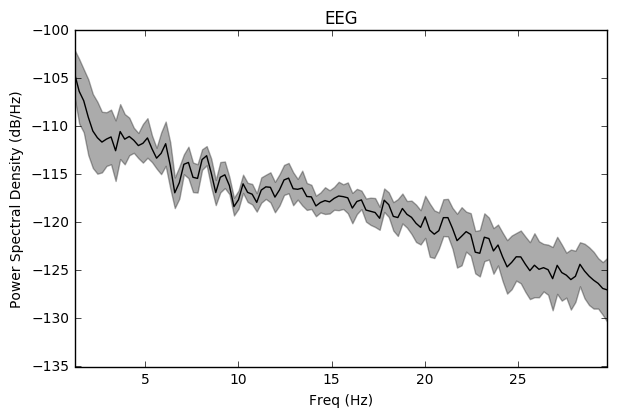

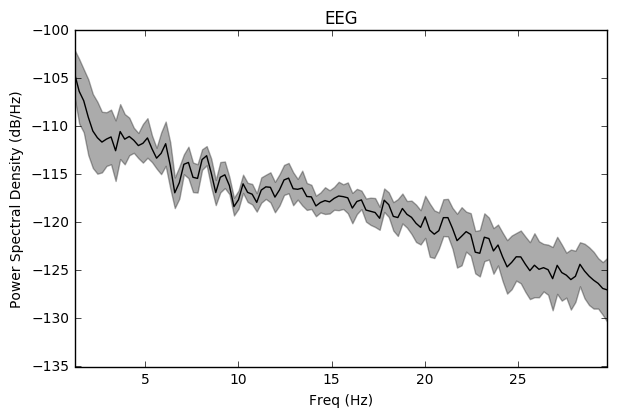

In [7]:
# plot psd
raw.plot_psd(fmin=1,fmax=30)

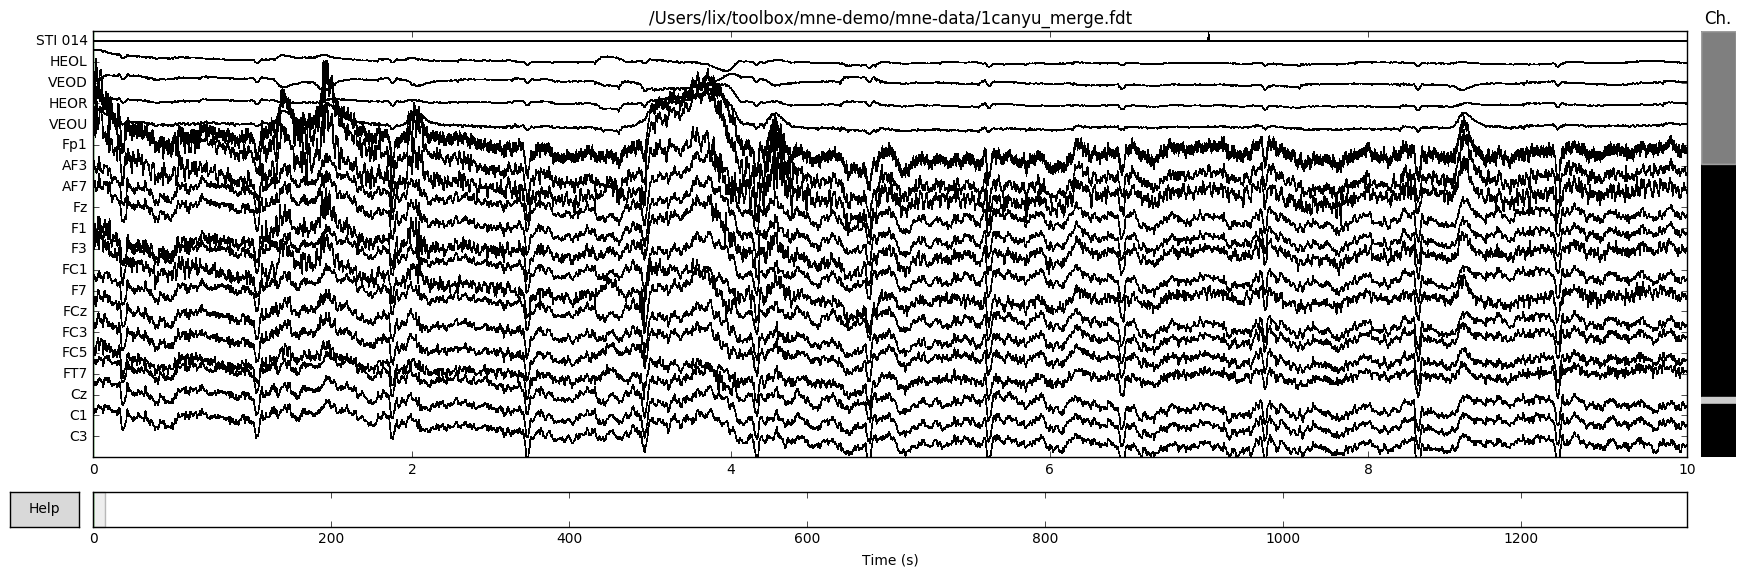

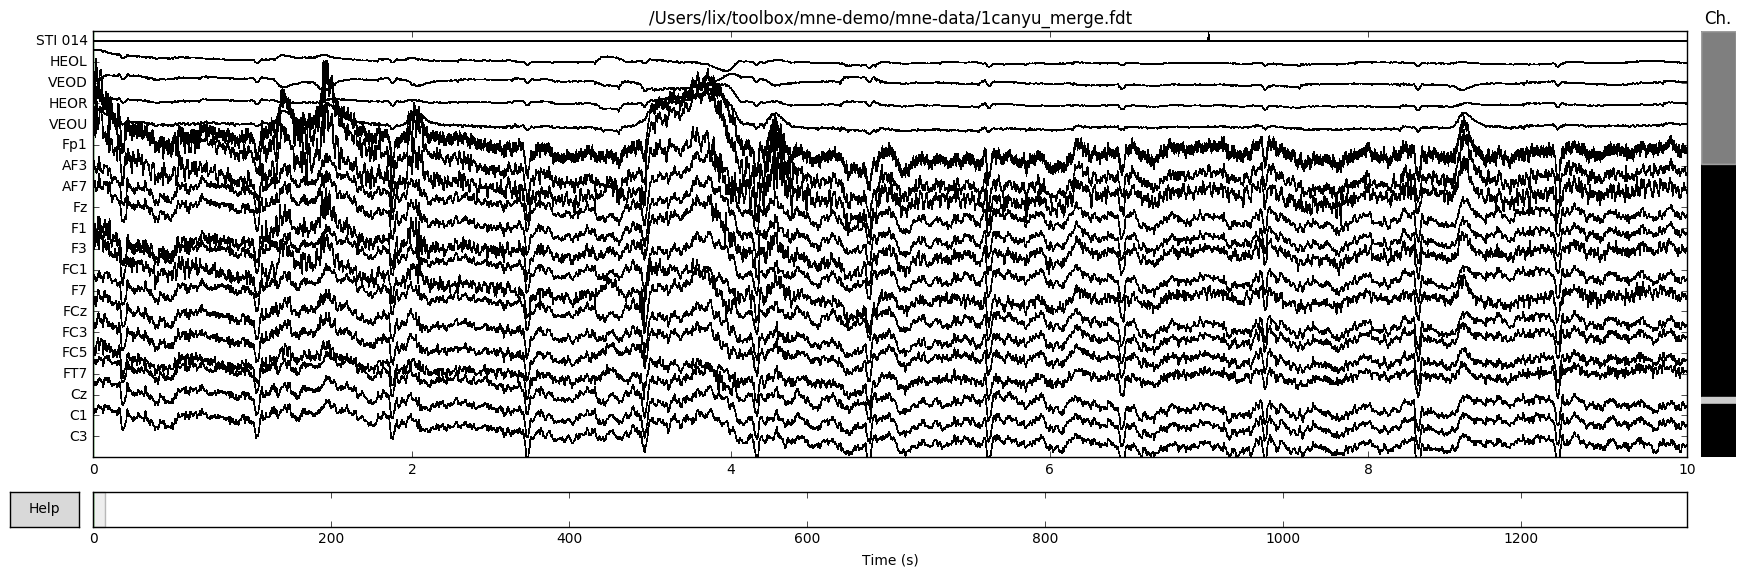

In [8]:
# plot raw data
plt.figure(2)
raw.plot(block=True)

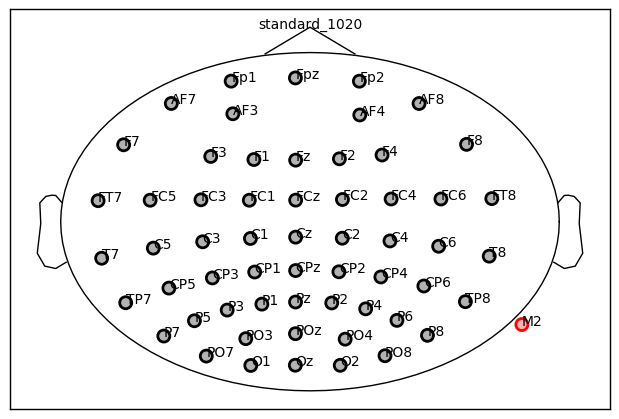

(<matplotlib.figure.Figure at 0x12273e650>, [])

In [9]:
# plot sensors
raw.plot_sensors(kind='select',
                 ch_type='all',
                 title='standard_1020',
                 show_names=True,
                 block=True)

In [ ]:
# --------------------------- ICA ------------------------------
# filter & resample
l_freq, h_freq, sfreq = 1, 40, 125
raw_filtered = raw.filter(l_freq, h_freq,
                          l_trans_bandwidth='auto',
                          h_trans_bandwidth='auto').resample(sfreq)

# --------------- ICA ---------------
picks = mne.pick_types(raw_filtered.info,
                       eeg=True,
                       eog=False,
                       stim=False,
                       exclude='bads')
rank_estimate = raw_filtered.estimate_rank(tstart=240.,
                                           tstop=540.,
                                           picks=picks)
ica = ICA(n_components=rank_estimate,
          max_pca_components=None,
          max_iter=256,
          method='fastica',
          random_state=23)
ica.fit(raw_filtered, picks=picks, decim=3)

Band-pass filtering from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-11-c3d85d0e86f8>:6: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  h_trans_bandwidth='auto').resample(sfreq)


200 events found
Events id: [11 22 33 44 55]
200 events found
Events id: [11 22 33 44 55]
estimated rank (eeg): 58
Fitting ICA to data using 58 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.


In [ ]:
ica.plot_components()

EOG channel index for this subject is: [31 62]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Band-pass filtering from 2 - 45 Hz
Band-pass filtering from 2 - 45 Hz
Band-pass filtering from 1 - 10 Hz
Now detecting blinks and generating corresponding events
Number of EOG events detected : 1842
1842 matching events found
No baseline correction applied
Loading data for 1842 events and 251 original time points ...
0 bad epochs dropped
EOG channel index for this subject is: [31 62]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Band-pass filtering from 2 - 45 Hz
Band-pass filtering from 2 - 45 Hz
Band-pass filtering from 1 - 10 Hz
Now detecting blinks and generating corresponding events
Number of EOG events detected : 1842
1842 matching events found
No baseline correction applied
Loading data for 1842 events and 251 original time points ...
0 bad epochs dropped


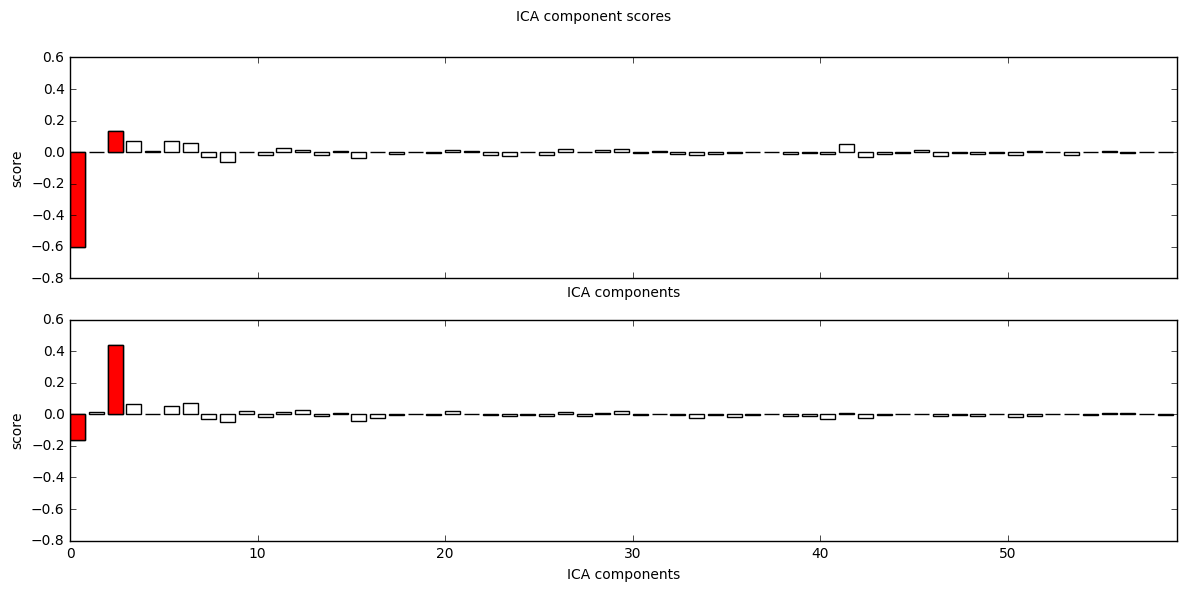

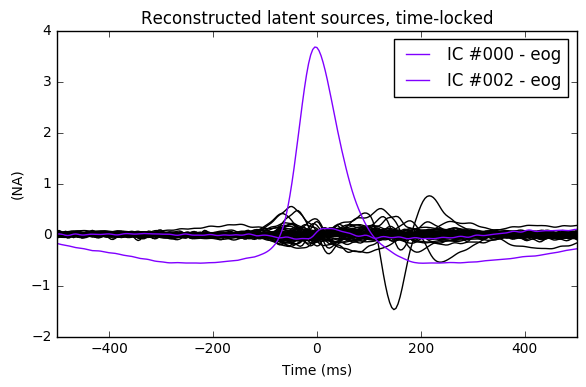

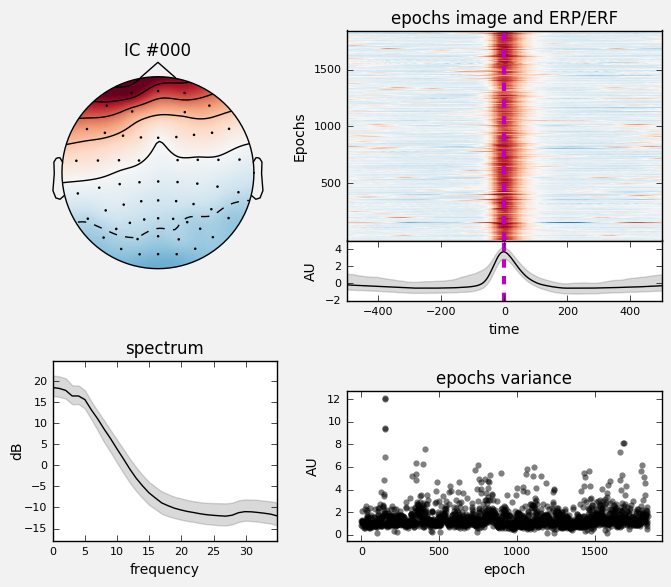

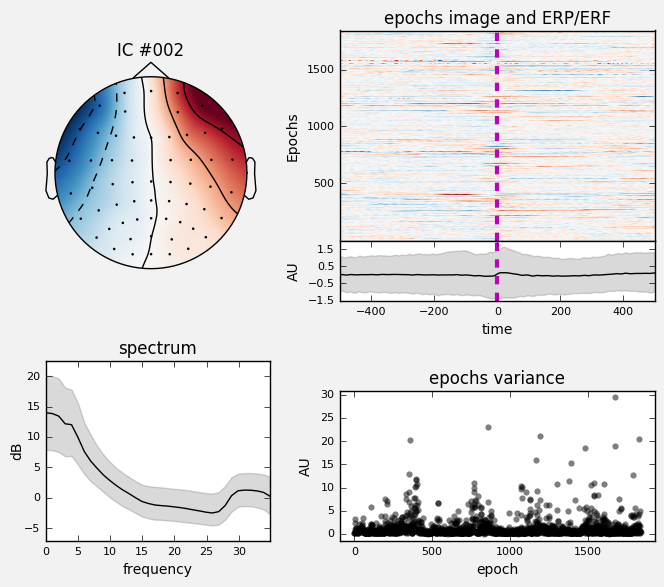

Transforming to ICA space (59 components)
Zeroing out 2 ICA components


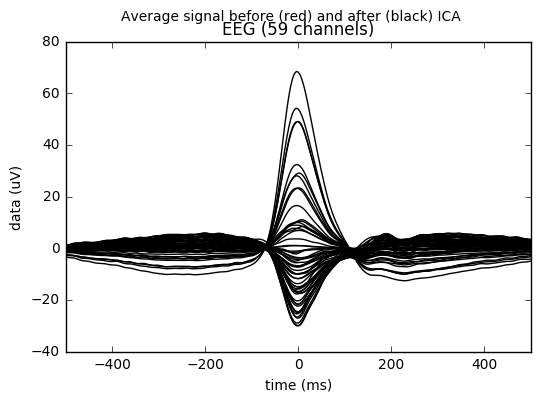

Writing ica solution to /Users/lix/toolbox/mne-demo/mne-data//demo-ica.fif...


<ICA  |  raw data decomposition, fit (fastica): 201870 samples, 59 components, channels used: "eeg", 2 sources marked for exclusion>

In [36]:
# --------------- EOG ---------------
eog_average = create_eog_epochs(raw_filtered,
                                picks=picks).average()

n_max_eog = 4
eog_epochs = create_eog_epochs(raw_filtered)
eog_inds, scores = ica.find_bads_eog(eog_epochs)

ica.plot_scores(scores, exclude=eog_inds)
ica.plot_sources(eog_average, exclude=eog_inds)  # look at source time course
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.})

ica.plot_overlay(eog_average, exclude=eog_inds, show=True)
ica.exclude.extend(eog_inds)
ica.save(fpath + '/demo-ica.fif')

In [60]:
# --------------- Apply ICA ---------------
l_freq_erp, h_freq_erp = 0.1, 40
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
raw_icaed = raw_no_ref.filter(l_freq_erp,
                       h_freq_erp,
                       l_trans_bandwidth='auto',
                       h_trans_bandwidth='auto')
ica.apply(raw_icaed, exclude=eog_inds)
#raw_icaed.pick_types(eeg=True, eog=False, stim=False, exclude='bads')
#raw_icaed = mne.add_reference_channels(raw_icaed, 'FCz', copy=False)
#raw_icaed.set_montage(montage)
mne.set_eeg_reference(raw_icaed, ref_channels=[])

Band-pass filtering from 0.1 - 40 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
Attenuation at stop frequency 0.0Hz is only 15.1dB. Increase filter_length for higher attenuation.


<ipython-input-60-f8e50b1214fb>:8: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  h_trans_bandwidth='auto')
<ipython-input-60-f8e50b1214fb>:8: RuntimeWarning: Attenuation at stop frequency 0.0Hz is only 15.1dB. Increase filter_length for higher attenuation.
  h_trans_bandwidth='auto')


Transforming to ICA space (59 components)
Zeroing out 2 ICA components
Applying a custom EEG reference.


(<RawBrainVision  |  s3-er.eeg, n_channels x n_times : 64 x 1211220 (2422.4 sec), ~591.5 MB, data loaded>,
 None)

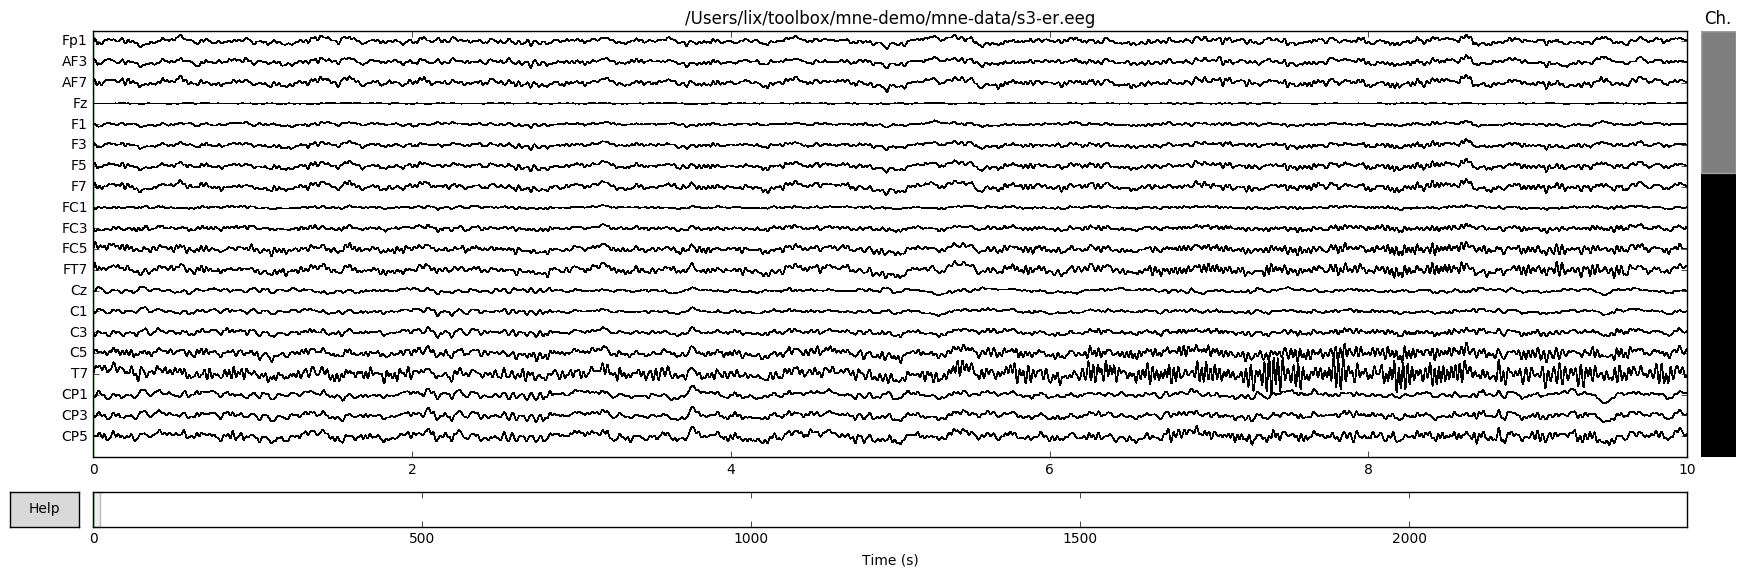

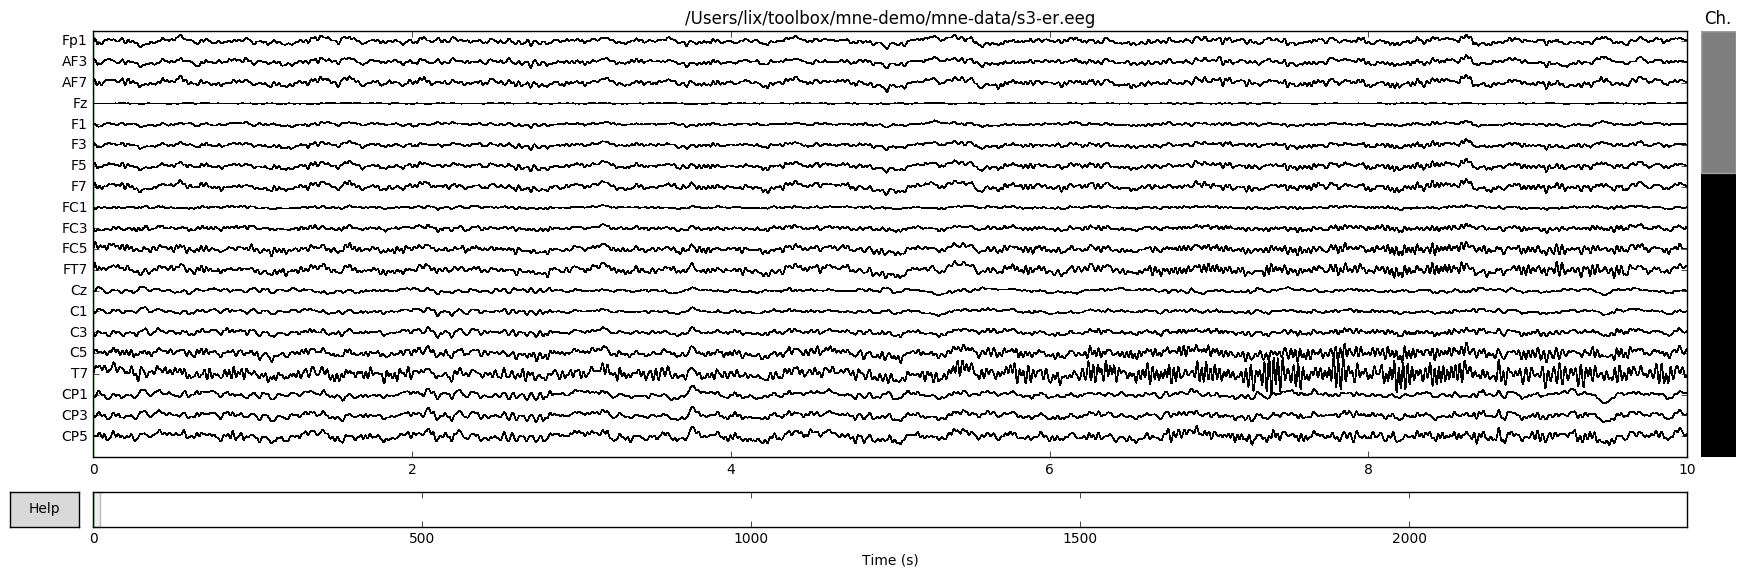

In [56]:
raw_icaed.plot(block=True)

In [126]:
# --------------- Epoch ---------------
sfreq = 250
events = mne.find_events(raw_icaed)
picks = mne.pick_types(raw_icaed.info,
                       eeg=True,
                       eog=False,
                       stim=True,
                       exclude='bads')
epochs = mne.Epochs(raw_icaed,
                    events=events,
                    event_id=events_id,
                    tmin=tmin,
                    tmax=tmax,
                    baseline=(None, 0),
                    picks=picks,
                    reject=dict(eeg=100e-6),
                    add_eeg_ref=False,
                    preload=True)
epochs.resample(sfreq)

232 events found
Events id: [ 1  2  3  5 11 22 33 44 55]
200 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 200 events and 2101 original time points ...
    Rejecting  epoch based on EEG : [u'T8']
    Rejecting  epoch based on EEG : [u'Fp1', u'AF3', u'AF7', u'F3', u'F5', u'F7', u'FC3', u'FC5', u'FT7', u'C3', u'C5', u'T7', u'CP1', u'CP3', u'CP5', u'TP7', u'Pz', u'P1', u'P3', u'P5', u'P7', u'PO3', u'PO7', u'Oz', u'O1', u'Fp2', u'AF4', u'AF8', u'F2', u'F4', u'F6', u'F8', u'FC2', u'FC4', u'FC6', u'FT8', u'C4', u'C6', u'T8', u'CPz', u'CP4', u'CP6', u'TP8', u'P2', u'P4', u'P6', u'P8', u'POz', u'PO4', u'PO8', u'O2']
    Rejecting  epoch based on EEG : [u'F7', u'FT7', u'T7', u'TP7', u'Oz', u'F6', u'FT8', u'T8', u'TP8']
    Rejecting  epoch based on EEG : [u'Oz', u'FC6', u'FT8', u'C6', u'T8', u'O2']
    Rejecting  epoch based on EEG : [u'AF7', u'F7', u'FC5', u'FT7', u'C5', u'T7', u'CP5', u'TP7', u'P5', u'P7', u'PO3', u'PO7', u'Oz', 

<Epochs  |  n_events : 171 (all good), tmin : -0.2 (s), tmax : 4.0 (s), baseline : (None, 0), ~82.4 MB, data loaded,
 'f/neg': 32, 'f/neu': 38, 'r/neg': 32, 's/neg': 35, 'sr/neg': 34>

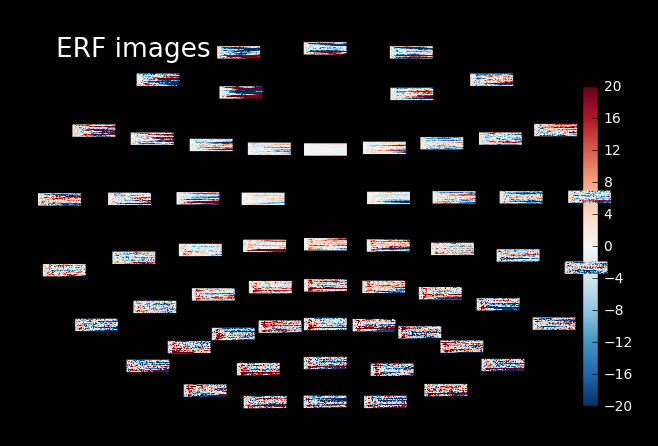

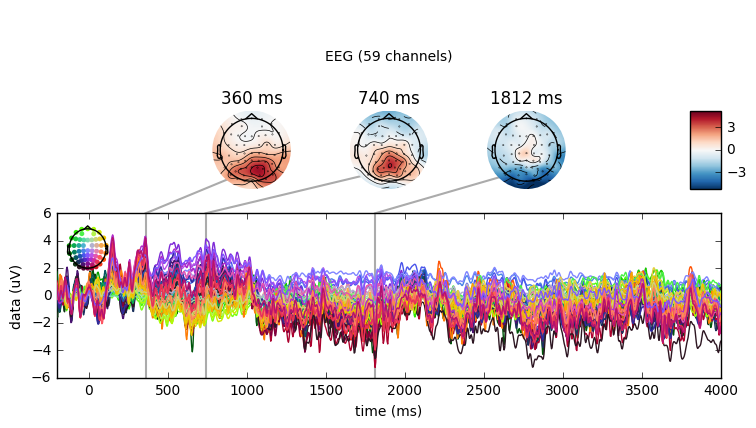

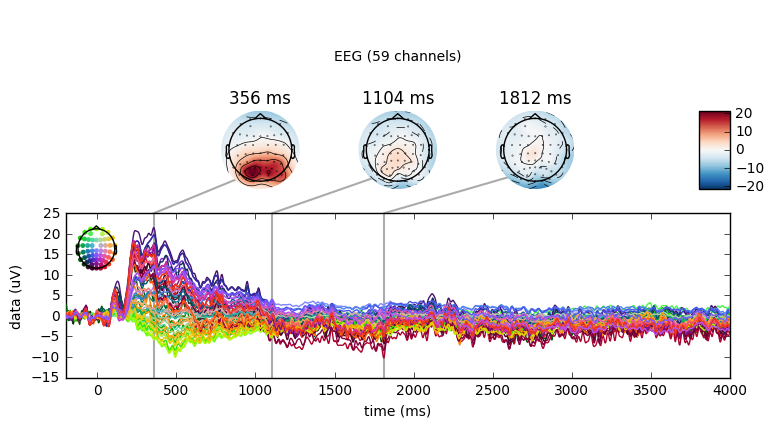

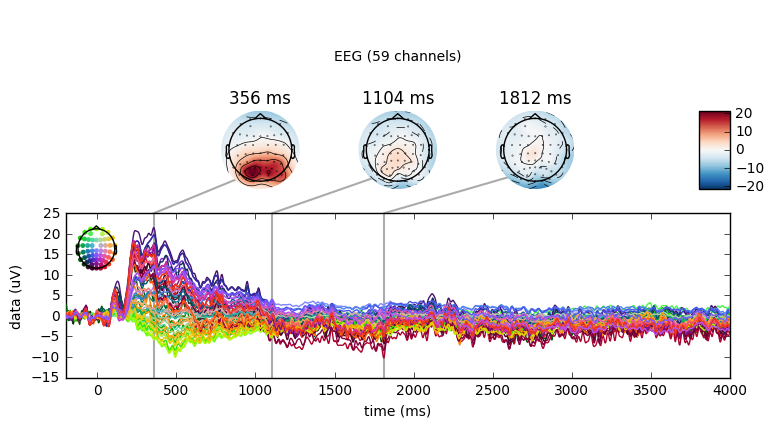

In [63]:
# plot epochs data
picks_epochs = mne.pick_types(epochs.info, eeg=True)
fneg = epochs['f/neg'].average()
fneu = epochs['f/neu'].average()
epochs['f/neg'].plot_topo_image(vmin=-20, vmax=20, title='ERF images')
mne.combine_evoked([fneg, -fneu], weights='equal').plot_joint()
fneg.plot_joint()

In [128]:
pz_index = mne.pick_channels(epochs.info['ch_names'], include=['Pz'])
pz_fneg = epochs['f/neg'].average().pick_types(include='Pz')
pz_fneu = epochs['f/neu'].average().pick_types(include='Pz')
pz_sneg = epochs['s/neg'].average().pick_types(include='Pz')
pz_rneg = epochs['r/neg'].average().pick_types(include='Pz')
plt.figure(1)
plt.plot(pz_fneg.times, pz_fneg.data.transpose(), 'r', label='FreeView: Negative', hold=True)
plt.plot(pz_fneu.times, pz_fneu.data.transpose(), 'b', label='FreeView: Neutral')
plt.plot(pz_sneg.times, pz_sneg.data.transpose(), 'g', label='Suppression')
plt.plot(pz_rneg.times, pz_rneg.data.transpose(), 'y', label='Reappraisal')
plt.xlim((-0.2, 2))
plt.legend(loc='upper right')
fh_pz = plt.gcf()
fh_pz.set_size_inches((10,6))
plt.show()

ValueError: No channels match the selection.

In [139]:
mne.pick_channels(epochs.info['ch_names'], include=['Pz'])

array([21])

In [150]:
cpz_fneg = epochs['f/neg'].copy().pick_types(include=['FCz']).average()
cpz_fneu = epochs['f/neu'].copy().pick_types(include=['FCz']).average()
cpz_sneg = epochs['s/neg'].copy().pick_types(include=['FCz']).average()
cpz_rneg = epochs['r/neg'].copy().pick_types(include=['FCz']).average()
plt.figure(2)
plt.plot(cpz_fneg.times, cpz_fneg.data.transpose(), 'r', label='FreeView: Negative', hold=True)
plt.plot(cpz_fneu.times, cpz_fneu.data.transpose(), 'b', label='FreeView: Neutral')
plt.plot(cpz_sneg.times, cpz_sneg.data.transpose(), 'g', label='Suppression')
plt.plot(cpz_rneg.times, cpz_rneg.data.transpose(), 'y', label='Reappraisal')
plt.xlim((-0.2, 2))
plt.legend(loc='upper right')
cf_cpz = plt.gcf()
cf_cpz.set_size_inches((6,4))
plt.show()

ValueError: No channels match the selection.

In [125]:
epochs.info['ch_names']

[u'Pz']

In [141]:
mne.pick_types?